# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [83]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [84]:
from sklearn.datasets import load_boston

In [85]:
boston = load_boston()

In [86]:
X = boston["data"]
y = boston["target"]

In [87]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [88]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.65188679937537

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [89]:
import numpy.random as rand

def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    
    size = X.shape[0]
    bias = np.empty((size, num_runs))
    bias.fill(np.nan)
    err = []
    for i in range(num_runs):
        indexes = np.random.randint(0, size, size)
        out_of_bag = np.delete(np.arange(size), np.unique(indexes))
        X_train = X[[indexes]]
        y_train = y[[indexes]]
        reg = regressor.fit(X_train, y_train)
        X_test = X[[out_of_bag]]
        y_test = y[[out_of_bag]]
        y_pred = reg.predict(X_test)
        bias[out_of_bag, i] = y_pred
        err.append(np.mean(np.square(y_pred - y_test)))
    variance = np.nanmean((np.nanvar(bias, axis=1)))
    bias = np.nanmean(np.square(np.nanmean(bias, axis=1) - y))
    error = np.mean(err)
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


regs = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
index = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor']
columns = ['bias', 'variance', 'error']
answer = pd.DataFrame(columns = columns, index = index)
for i in range(len(regs)):
    answer.loc[index[i],:] = compute_biase_variance(regs[i], X, y)
answer

,bias,variance,error
LinearRegression,23.7504,0.957277,24.875
DecisionTreeRegressor,10.2532,13.1914,23.6032
RandomForestRegressor,10.7727,2.27737,13.1242


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ 
* Из лекции знаем, что смещение показывает, насколько хорошо можно приблизить оптимальный алгоритм с помощью даных метода обучения и семейства алгоритмов. Утверждалось, что маленькое смещение характерно сложным семействам (деревья), а большое простым (линейный регрессор), ведь простые модели далеко не всегда могут повторить сложные зависимости выборки. Это же мы можем видеть в нашем эксперименте. Bias линейной регрессии заметно больше, чем bias дерева решений и случайного леса. Так же заметим, что смещение дерева и леса практически идентичное, так как путем бэггинга(усреднения) смещение не меняется.

* Опять же из лекции: дисперсия показывает, насколько сильно может изменяться ответ обученного алгоритма в зависимости от выборки. Говорилось, что простые семейства имеют маленькую дисперсию, а сложные -- большую. Действительно, простые предсказания каждый раз мало отличаются друг от друга, а в сложных могут появляьтся новые зависимости. Как и в нашем алгоритме: variance простой модели линейной регрессии меньше единицы, в то время как variane дерева решений около 14. Обратим внимание на то, что дисперсия случайного леса так же небольшая, хотя модель кажется сложной. Это просходит из-за того, что случайный лес -- это по сути бэггинг над решающими деревьями, а на лекции было показано, что бэггинг позволяет объединить несмещенные, но чувствительные к обучающей выборке алгоритмы в несмещенную композицию с низкой дисперсией.

* Ошибка в данном случае -- это сумма смещения, разброса и шума. Можно заметить, что сумма bias и variance примерно равна error, то есть исходные данные зашумлены совсем немного. 

* В общем и целом, результат эксперимента совпадает с тем, что было продемонстрировано на лекции.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__
* Из лекции: смещение композиции, полученной с помощью бэггинга, совпадает со смещением одного базового алгоритма. Здесь ровно это и видим. Смещение каждого алгоритма практически совпадает со смещением без бэггинга.

* С разбросом ситуация обстоит иначе. На лекции было показано, что если базовые алгоритмы некоррелированы, то дисперсия композиции в N раз меньше дисперсии отдельных алгоритмов, а если корреляция имеет место, то уменьшение не так существенно. Обратим внимание, что функция BaggingRegressor из sklearn по дефолту использует 10 моделей base estimators в композиции. Рассмотрим каждый подход отдельно:

* *Линейная регрессия*. Выше было показано, что алгоритмы сильно коррелировали, из-за этого мы и не ожидаем каких-то феноманальных результатов от бэггинга. Разброс практически не изменился, сохранившись в районе 1.

* *Дерево решений*. Как уже говорилось, бэггинг над деревом решений по сути является случайным лесом и проводится как раз для того, чтобы уменьшить разброс. Здесь это и осуществлено. С 13 variance уменьшился до 3,4, то есть примерно в 4 раза. Это, конечно, не 10, но нельзя сказать, что алгоритмы совсем не коррелировали, иначе смещение бы было очень близко к 0.

* *Случайный лес*. Здесь разброс уменьшился практически в 1,5 раза. В данном случае мы буквально проводим бэггинг над бэггингом. Скорее всего, не произошло резкого уменьшения разброса по той причине, что все-таки результаты предсказаний исходных деревьев между собой как никак коррелировали, мы навесили на это бэггинг, получили лес, все более-менее улучшилось, но последующий бэггинг уже не дал явных изменений, так как леса между собой коррелируют за счет использованных деревьев.

* Итого, результаты эксперимента не противоречат сказанному на лекции. Чем меньше корреляция моделей, тем сильнее уменьшится разброс.

In [91]:
from sklearn.ensemble import BaggingRegressor


answer = pd.DataFrame(columns = columns, index = index)
for i in range(len(regs)):
    regr = BaggingRegressor(base_estimator=regs[i])
    answer.loc[index[i],:] = compute_biase_variance(regr, X, y)
answer

,bias,variance,error
LinearRegression,23.7457,1.03158,24.5563
DecisionTreeRegressor,10.6617,3.4626,14.0955
RandomForestRegressor,11.5788,1.40416,12.9337


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [92]:
def plot_predictions(regressor, ax, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    size = X.shape[0]
    test = np.random.choice(size, num_test_objects, replace = False)
    train = np.delete(np.arange(size), test)
    X_test = X[[test]]
    y_test = y[[test]]
    X_train = X[[train]]
    y_train = y[[train]]
    size = X_train.shape[0]
    for i in range(num_runs):
        indexes = np.random.randint(0, size, size)
        X_train = X[[indexes]]
        y_train = y[[indexes]]
        reg = regressor.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        ax.scatter(np.arange(num_test_objects), y_pred, c='lightblue')
    ax.scatter(np.arange(num_test_objects), y_pred, c='lightblue', label='Prediction') # костыль для красивого вывода легенды, 
    ax.scatter(np.arange(num_test_objects), y_test, c='black', label='True target')    # иначе можно было вставить условие
    ax.legend()                                                                        # в цикл, чтобы указать label в scatter
    ax.set_xlabel('num_test_objects')                                                  # только 1 раз, но точки рисуются быстро,
    ax.set_ylabel('predictions')                                                       # почему бы разово не продублировать их
    ax.set_title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

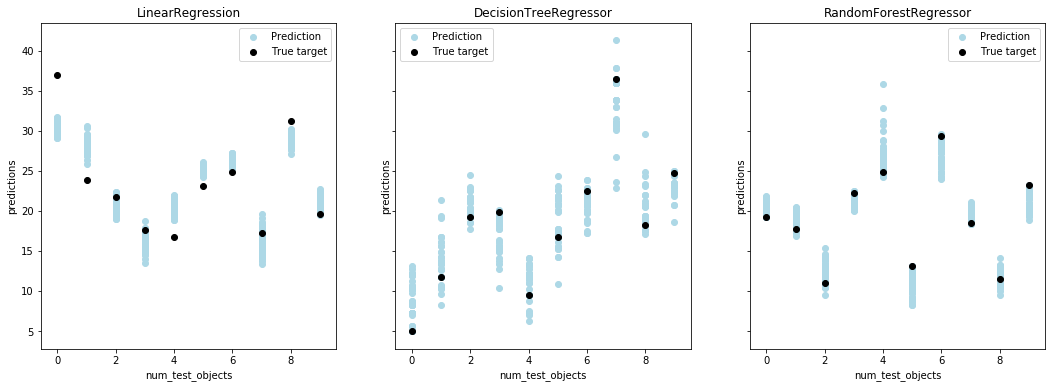

In [93]:
fig, ax = plt.subplots(1, 3, sharey='row', figsize=(18, 6))
for i in range(len(regs)):
    plot_predictions(regs[i], ax[i], X, y, title=index[i])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
Сначала заметим, что сравнивать алгоритмы мы пытаемся не совсем честно, так как для каждого алгоритма считается своя тестовая выборка. Можно было бы определять ее одинаково для всех, чтобы сравнивать смещение и разброс, относительно одного верного ответа, но нас просят проводить разделение именно в функции, а мы ее вызываем для каждого алгоритма отдельно :(

Так же зафиксируем, что смещение на таком графике определяется близостью голубых точек в одном столбце к чёрной точке: чем ближе, тем смещение меньше. А разброс -- условная высота столбца, относительно самой нижней голубой точки и самой верхней в одном столбике. Чем такая высота больше, тем больше разброс.
* *Линейная регрессия*. Как и было показано в предыдущих заданиях, для линейной регрессии характерен небольшой разброс. Действительно, по сравнению с другими алгоритмами изменение обучающей выборки не сильно влияет на предсказание, так как модель простая и не может выдавать кардинально новые результаты. Смещение здесь немаленькое, каким и должно быть, исходя из лекции, относительно других алгоритмов. Прогнозы либо больше фактического ответа, либо меньше. Это также логично, вряд ли зависимости реального ответа от признаков линейны. 
* *Дерево решений*. Результаты так же совпадают с лекционными "мишенями". Разброс в данном случае большой, так как модель сложная, и изменения в выборке влекут изменения предсказаний. А смещение не такое большое, при усреднении предсказаний мы как раз попадем в значение фактического таргета (или в область рядом с ним). 
* *Случайный лес*. Здесь заметно уменьшается разброс. Он даже приближается по соему диапазону к показаниям линейного регрессора. Это произошло за счет бэггинга внутри модели. Смещение так же мало отличается от смещения в деревьях, заметим, что мы не имеем такого объекта, фактический ответ которого лежал бы не в диапазоне предсказания. Следовательно, случайный лес действительно дает лучшие результаты.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

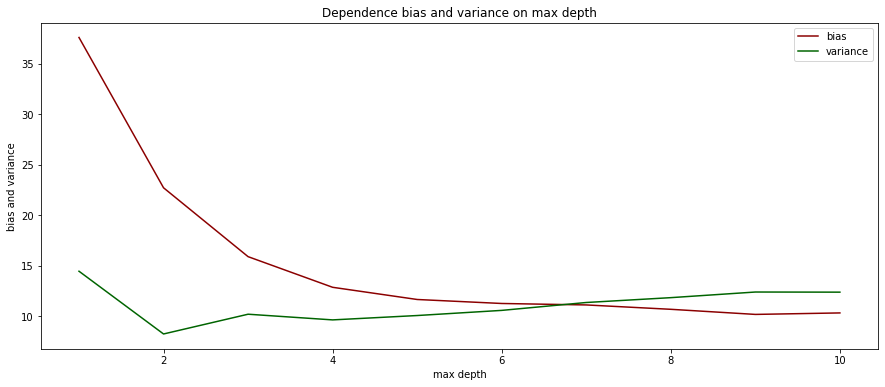

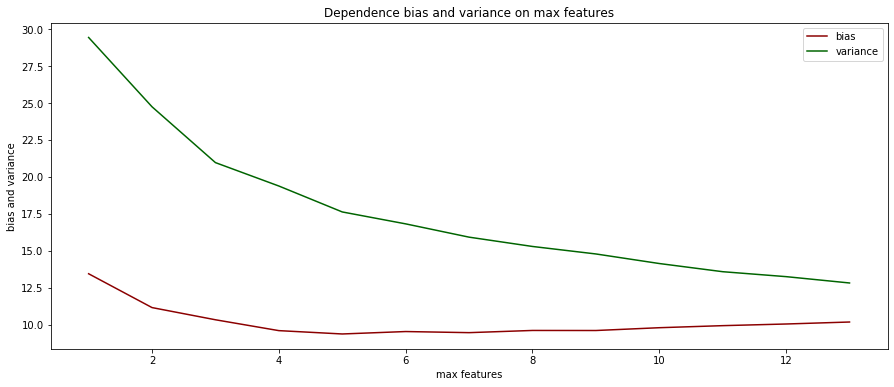

In [94]:
fig, ax = plt.subplots(figsize=(15, 6))
bias = []
variance = []
depth = []
for max_depth in range(1, 11):
    curr = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X, y)
    depth.append(max_depth)
    bias.append(curr[0])
    variance.append(curr[1])
ax.plot(depth, bias, label='bias', c='darkred')
ax.plot(depth, variance, label='variance', c='darkgreen')
ax.set_xlabel('max depth')
ax.set_ylabel('bias and variance')
ax.set_title('Dependence bias and variance on max depth')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
bias = []
variance = []
features = []
for max_features in range(1, X.shape[1] + 1):
    curr = compute_biase_variance(DecisionTreeRegressor(max_features=max_features), X, y)
    features.append(max_features)
    bias.append(curr[0])
    variance.append(curr[1])
ax.plot(features, bias, label='bias', c='darkred')
ax.plot(features, variance, label='variance', c='darkgreen')
ax.set_xlabel('max features')
ax.set_ylabel('bias and variance')
ax.set_title('Dependence bias and variance on max features')
ax.legend()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:32:15<00:00, 615.07s/it]


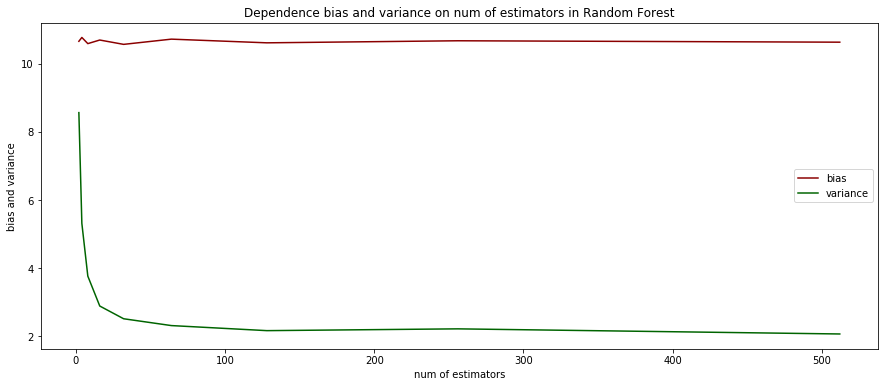

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [32:27<00:00, 216.41s/it]


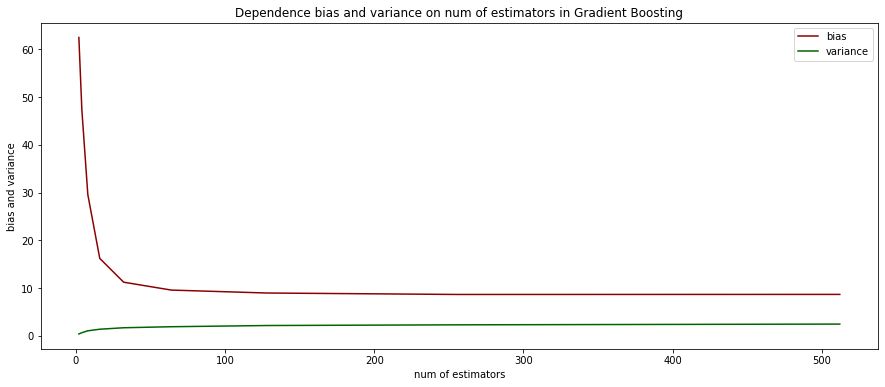

In [95]:
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm

fig, ax = plt.subplots(figsize=(15, 6))
bias = []
variance = []
estimators = 2**np.arange(1, 10)
for estimator in tqdm(estimators):
    curr = compute_biase_variance(RandomForestRegressor(n_jobs=-1, n_estimators=estimator), X, y)
    bias.append(curr[0])
    variance.append(curr[1])
ax.plot(estimators, bias, label='bias', c='darkred')
ax.plot(estimators, variance, label='variance', c='darkgreen')
ax.set_xlabel('num of estimators')
ax.set_ylabel('bias and variance')
ax.set_title('Dependence bias and variance on num of estimators in Random Forest')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
bias = []
variance = []
estimators = 2**np.arange(1, 10)
for estimator in tqdm(estimators):
    curr = compute_biase_variance(GradientBoostingRegressor(n_estimators=estimator), X, y)
    bias.append(curr[0])
    variance.append(curr[1])
ax.plot(estimators, bias, label='bias', c='darkred')
ax.plot(estimators, variance, label='variance', c='darkgreen')
ax.set_xlabel('num of estimators')
ax.set_ylabel('bias and variance')
ax.set_title('Dependence bias and variance on num of estimators in Gradient Boosting')
ax.legend()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
* *Зависимость смещения и разброса от максимальной глубины*. При увеличении глубины по началу смещение и разброс уменьшаются, но начиная с определенного значения, в данном случае 2, разброс постепенно увеличивается. Попробуем обосновать это интуитивно. Чем глубже дерево, тем точнее его прогнозы, но и больше вероятность переобучиться. Поэтому смещение становится все меньше, ведь предсказания приближаются к правильному ответу, но при этом их подгонка под обучение больше, за счет чего увеличивается разброс.
* *Зависимость смещения и разброса от максимального числа признаков*. В реализации леса в sklearn сказано, чем это значение ниже, тем сильнее уменьшение в разбросе, но и больше смещение. Там рекомендуют делать max_features=n_features. Это мы можем наблюдать и у нас: variance перманентно падает, в то время как bias сначала падает, а где-то с 5 начинает медленно увеличиваться. Если объяснить это интуитивно, то при увеличении подвыборки для разбиения к нам попадает больше признаков, соответственно разброс предсказаний уменьшается, так как изменения в выборке с каждым последующим шагом не так глобальны. На лекции рекомендовалось брать значение max_features равным $\frac d 3$, где d -- число признаков. В нашем случае признаков 13, то есть max_features должно быть 4. Такое оптимальное значение мы и видим на графике. По поводу смещения можно сказать, что это значение является характеристикой богатства семейства модели, а с определенного момента деревья при построении становятся более однообразными, то есть менее полезными и смещение будет больше. 
* *Зависимость смещения и разброса от числа деревьев в Случайном лесе*. Заметим, что на смещение их количество особо не влияет. Оно все время остается в районе 12. Это логично, ведь уже было показано, что смещение леса повторяет смещение деревьев, то есть при изменении их количества значение bias меняться не будет. Обратим внимание на то, что смещение примерно совпадает со значениями на предыдущих графиках, где были визуализированы деревья. Однако разброс резко падает при увеличении числа деревьев до 40. Далее оно сохраняет низкое значение, приближаясь к асимптоте 2. В библиотеке sklearn дефолтное оптимальное значение для этого параметра равно 100. Думаю, в нашем случае это тоже бы подошло, так как далее разница не сильно заметна, но времени на вычисление нужно больше.
* *Зависимость смещения и разброса от числа обучаемых моделей в Градиентном бустинге*. Поведение практически полностью противоположное. В данном случае разброс сохраняется низким, независимо от n_estimators. Зато смещение резко падает до 10 при увечеличении числа n_estimators до 50. В библиотеке sklearn можно найти описание того, что зачастую увеличение параметра n_estimators ведет к улучшению качества, так как модель градиентного бустинга не склонна переобучаться. Такое мы можем заметить и в нашем случае, при увеличении параметра, качество не падает, хоть и растет с определенного момента не так уж заметно. Это же было описано на лекции: благодаря бустингу можно понизить смещение моделей, а разброс либо останется таким же, либо увеличится (собственно, от 0 до примерно 20 он и увеличивается). Это происходит за счет того, что в бустинге каждый следующий алгоритм целенаправленно понижает ошибку композиции.